<h1/>PerPay Data Analysis Chanllenge


# <h2> 1. Data Quality Check

Check Pass: All data entry in user_dataset have matching records in order_dataset

In [34]:
import pandas as pd
user_data = pd.read_csv('user_dataset.csv')
order_data = pd.read_csv('order_dataset.csv')

timestamp_cols_user = ['signup_dt', 'last_login', 'first_application_start_ts', 'first_application_complete_ts',
                       'first_awaiting_payment_ts', 'first_repayment_ts']
timestamp_cols_order = ['application_start_ts', 'application_complete_ts', 'awaiting_payment_ts',
                        'repayment_ts', 'canceled_ts']

for col in timestamp_cols_user:
    user_data[col] = pd.to_datetime(user_data[col], errors='coerce')
for col in timestamp_cols_order:
    order_data[col] = pd.to_datetime(order_data[col], errors='coerce')

start_date = pd.to_datetime('2020-10-13')
end_date = pd.to_datetime('2020-11-06')

#Check for users that have first application start timestamp in user data but no matching record in order_data
users_in_range = user_data[(user_data['first_application_start_ts'] >= start_date) & (user_data['first_application_start_ts'] <= end_date)]
matching_users = users_in_range['user_id'].isin(order_data['user_id'])
missing_users_in_range = users_in_range.loc[~matching_users, 'user_id'].nunique()

results = {
    'Users in Range but No Matching Orders': missing_users_in_range,
}
for key, value in results.items():
    print(f"{key}:\n{value}\n")


Users in Range but No Matching Orders:
0



Potential Problem: Number of orders by a single user between '2020-10-13' and '2020-11-06'. Multiple orders with minimal conversion

In [35]:
import pandas as pd
orders_by_user = order_data.groupby('user_id').agg(
    total_orders=('user_id', 'count'),
    reached_repayment=('repayment_ts', 'count')
    )
orders_by_user = orders_by_user.sort_values(by='total_orders', ascending=False).reset_index()

top_100_users = orders_by_user.head(100)
print(top_100_users)


                                 user_id  total_orders  reached_repayment
0   878dfd26-9fb9-4c64-8c3b-c8ce198e90bd            16                  0
1   c1953798-8853-4222-af59-e87e118e223a            11                  1
2   17c79457-eb70-4de3-8682-35e4c3116850            11                  0
3   6c0284cf-b47d-437e-9fbe-01de24096e0e            11                  0
4   5e303889-e3e6-4c99-8bc5-8a1fe2d9fab7             9                  1
..                                   ...           ...                ...
95  4b4571b1-ce99-4500-86a4-4fbdbe31a26a             5                  0
96  3e23a5a6-a0fa-4c57-90b5-a9ea87fcd7b2             5                  0
97  f7ceb943-2655-43a9-bac3-9d71ab7a60f7             5                  0
98  12bc313e-a93c-4e61-98ee-cc9b91de0e37             5                  0
99  90b4886e-6d5d-4cbc-9a59-928b3a09cea9             5                  0

[100 rows x 3 columns]


Problem identified: 40 order cancellation doesn't have a reason. This is probably due to null value in the database

In [36]:
canceled_without_type = order_data[(order_data['canceled_ts'].notna()) & (order_data['cancellation_type'].isna())]
canceled_without_type_count = canceled_without_type.shape[0]
canceled_without_type_count


40

Check Pass: All first applications have macthing records in the order dataset

In [37]:
import pandas as pd
start_date = pd.to_datetime('2020-10-13')
end_date = pd.to_datetime('2020-11-06')

users_in_range = user_data[
    (user_data['first_application_start_ts'] >= start_date) &
    (user_data['first_application_start_ts'] <= end_date)
]
matching_users = users_in_range['user_id'].isin(order_data['user_id'])
missing_users_in_range = users_in_range.loc[~matching_users, 'user_id'].nunique()
matching_orders_count = order_data[order_data['user_id'].isin(users_in_range['user_id'])].shape[0]
print(f"Users with application start timestamp in user_data but no matching order in order_dataset: {missing_users_in_range}")


Users with application start timestamp in user_data but no matching order in order_dataset: 0


Problems identified: 158 entries have sign-up time after first application time. This indicating issue in recording data.

In [38]:
import pandas as pd

#Check for timestamp sequence in user_data
user_data_issues = user_data[
    (user_data['first_application_complete_ts'] < user_data['first_application_start_ts']) |
    (user_data['first_awaiting_payment_ts'] < user_data['first_application_complete_ts']) |
    (user_data['first_repayment_ts'] < user_data['first_awaiting_payment_ts']) |
    (user_data['first_application_start_ts'] < user_data['signup_dt'])  # Check if application start is before signup
]

#Check for timestamp sequence in order_data
order_data_issues = order_data[
    (order_data['application_complete_ts'] < order_data['application_start_ts']) |
    (order_data['awaiting_payment_ts'] < order_data['application_complete_ts']) |
    (order_data['repayment_ts'] < order_data['awaiting_payment_ts'])
]

user_data_issues_count = user_data_issues.shape[0]
order_data_issues_count = order_data_issues.shape[0]

print(f"Number of time sequencial problematic entries in user_data:", user_data_issues_count)
print(f"Number of time sequencial entries in order_data:", order_data_issues_count)

Number of time sequencial problematic entries in user_data: 158
Number of time sequencial entries in order_data: 0


#<h2>2. Data Processing

<h3> 1.1 User Data Processing</h3>


In [39]:
import pandas as pd

user_data = pd.read_csv('user_dataset.csv')
timestamp_cols = ['signup_dt', 'last_login','first_application_start_ts', 'first_application_complete_ts',
                  'first_awaiting_payment_ts', 'first_repayment_ts']
for col in timestamp_cols:
    user_data[col] = pd.to_datetime(user_data[col], errors='coerce')

user_data['uploaded_paystub'] = user_data['first_paystub_dt'].notna().astype(int)
user_data['entered_application'] = user_data['first_application_start_ts'].notna().astype(int)
user_data['completed_application'] = user_data['first_application_complete_ts'].notna().astype(int)
user_data['entered_approval'] = user_data['first_awaiting_payment_ts'].notna().astype(int)
user_data['entered_repayment'] = user_data['first_repayment_ts'].notna().astype(int)

user_data['put_in_salary_info'] = user_data['spending_limit_est'].notna().astype(int)

user_data['company_name'] = user_data['company_name'].replace('Other > Add a new company', pd.NA)

user_data['time_start_to_complete'] = (user_data['first_application_complete_ts'] - user_data['first_application_start_ts']).dt.total_seconds() / 3600
user_data['time_complete_to_approval'] = (user_data['first_awaiting_payment_ts'] - user_data['first_application_complete_ts']).dt.total_seconds() / 3600
user_data['time_approval_to_repayment'] = (user_data['first_repayment_ts'] - user_data['first_awaiting_payment_ts']).dt.total_seconds() / 3600

user_data.head()


,user_id,signup_dt,company_name,spending_limit_est,valid_phone_ind,last_login,was_referred_ind,first_paystub_dt,first_application_start_ts,first_application_complete_ts,...,first_repayment_ts,uploaded_paystub,entered_application,completed_application,entered_approval,entered_repayment,put_in_salary_info,time_start_to_complete,time_complete_to_approval,time_approval_to_repayment
0,cee2d1d9-5941-48c5-baf8-8fec32037231,2020-10-13 00:04:12.382388,<NA>,1000.0,1,2022-11-22 14:58:59.393515,0,NaN,2020-10-13 00:06:54.570878,2022-11-22 14:58:54.656900,...,NaT,0,1,1,1,0,1,18494.866691,0.000977,NaN
1,7a76382d-65cf-4608-84a2-61fa13c4a3eb,2020-10-13 00:04:53.295693,Coca-Cola Company,960.0,1,2021-11-29 01:06:21.588189,0,NaN,2020-10-13 00:28:45.179575,NaT,...,NaT,0,1,0,0,0,1,NaN,NaN,NaN
2,748add0f-d9db-43db-b874-1dd6e39a12ff,2020-10-13 00:06:18.867563,Bi-Lo,633.6,1,2020-10-27 05:43:58.829529,0,NaN,NaT,NaT,...,NaT,0,0,0,0,0,1,NaN,NaN,NaN
3,165aa72f-2ad4-4a60-900c-9f3cb801ec7f,2020-10-13 00:09:49.809019,<NA>,NaN,0,2020-10-13 00:10:33.701589,0,NaN,NaT,NaT,...,NaT,0,0,0,0,0,0,NaN,NaN,NaN
4,8ae8ecdf-95d1-465a-9679-d0cfdcc15eca,2020-10-13 00:11:37.674595,Morgan Properties,1000.0,1,2020-10-13 00:47:26.172442,0,NaN,NaT,NaT,...,NaT,0,0,0,0,0,1,NaN,NaN,NaN


<h3>1.2 Order Data Processing</h3>

In [40]:
import pandas as pd

order_data = pd.read_csv('order_dataset.csv')
timestamp_cols = ['application_start_ts', 'application_complete_ts',
                  'awaiting_payment_ts', 'repayment_ts', 'canceled_ts']
for col in timestamp_cols:
    order_data[col] = pd.to_datetime(order_data[col], errors='coerce')

order_data['entered_application'] = order_data['application_start_ts'].notna().astype(int)
order_data['completed_application'] = order_data['application_complete_ts'].notna().astype(int)
order_data['entered_awaiting_payment'] = order_data['awaiting_payment_ts'].notna().astype(int)
order_data['entered_repayment'] = order_data['repayment_ts'].notna().astype(int)
order_data['canceled'] = order_data['canceled_ts'].notna().astype(int)

#Time differences in hours between each funnel stage
order_data['time_start_to_complete'] = (order_data['application_complete_ts'] - order_data['application_start_ts']).dt.total_seconds() / 3600
order_data['time_complete_to_approval'] = (order_data['awaiting_payment_ts'] - order_data['application_complete_ts']).dt.total_seconds() / 3600
order_data['time_approval_to_repayment'] = (order_data['repayment_ts'] - order_data['awaiting_payment_ts']).dt.total_seconds() / 3600

print (order_data.columns)
order_data.head()


Index(['order_id', 'user_id', 'amount', 'number_of_payments',
       'user_pinwheel_eligible_at_ap', 'approval_type', 'application_start_ts',
       'application_complete_ts', 'awaiting_payment_ts', 'repayment_ts',
       'canceled_ts', 'cancellation_type', 'risk_tier_at_uw',
       'entered_application', 'completed_application',
       'entered_awaiting_payment', 'entered_repayment', 'canceled',
       'time_start_to_complete', 'time_complete_to_approval',
       'time_approval_to_repayment'],
      dtype='object')


,order_id,user_id,amount,number_of_payments,user_pinwheel_eligible_at_ap,approval_type,application_start_ts,application_complete_ts,awaiting_payment_ts,repayment_ts,...,cancellation_type,risk_tier_at_uw,entered_application,completed_application,entered_awaiting_payment,entered_repayment,canceled,time_start_to_complete,time_complete_to_approval,time_approval_to_repayment
0,30abad45-494e-49d3-a1a3-f7a97d4cd393,c137026a-591a-48bc-9c35-3ced4dd1d6b9,679.98,NaN,0,NaN,2020-10-13 00:08:44.623975,NaT,NaT,NaT,...,automated.application_started,T0,1,0,0,0,1,NaN,NaN,NaN
1,f22245c6-eb1e-47ae-82cc-aea02c2c3f5c,30b8266a-defa-49c2-a73a-78f2de30ca5b,707.98,4.0,0,NaN,2020-10-13 00:32:57.036371,NaT,NaT,NaT,...,other_interests,T0,1,0,0,0,1,NaN,NaN,NaN
2,085a679e-68c5-47e7-957d-847fc2e052cd,20b84834-6265-41ce-a754-f3465f01dd1e,489.98,4.0,0,NaN,2020-10-13 00:37:29.388580,2020-10-13 00:39:49.212296,NaT,NaT,...,automated.pending,T0,1,1,0,0,1,0.03884,NaN,NaN
3,ec3ab25f-c5ac-4fe9-be70-2413653b2448,eb99e759-c3dc-4453-ad63-58a45d8fdaec,137.14,4.0,1,NaN,2020-10-13 00:37:54.567440,NaT,NaT,NaT,...,automated.application_started,T0,1,0,0,0,1,NaN,NaN,NaN
4,cf999f3e-d9cf-46dd-a40d-bfbf15c1bddd,8b42d699-4494-4fd1-9026-6b884520ad23,105.94,8.0,1,underwriting.auto.ftb_decision,2020-10-13 00:41:00.760569,2020-10-19 20:13:55.361498,2020-10-19 20:13:57.232453,NaT,...,spending_limit_exceeded,T0,1,1,1,0,1,163.54850,0.00052,NaN


All orders that enter repayment are not cancelled. Likely to be the policy.

In [41]:
successful_repayments = order_data[order_data['entered_repayment'] == 1]
canceled_summary = successful_repayments['canceled'].describe()
canceled_summary

,canceled
count,1498.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#<h2>3. Know Your Customers</h3>


<h4>3.1 Investgating user lifetime</h4>
<li>The majority of users have a lifetime of 0 days. This means they signed up but never logged in again. This suggests a significant drop-off or disengagement right after the initial sign-up, indicating a potential issue with user onboarding or engagement.</li>
<li> There are clusters of customers  at intervals beyond 1,000 days.  This tells me that a subset of users remains engaged for a longer duration.
These users may represent a loyal segment of the user base, possibly contributing to consistent usage or higher conversion rates.</li>
<li>There are some spikes at around the holiday season, but without further context it's hard to tell what may be the reason. </li>

<ipython-input-42-f616616447e8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_user_data['user_lifetime_days'] = (valid_user_data['last_login'] - valid_user_data['signup_dt']).dt.days


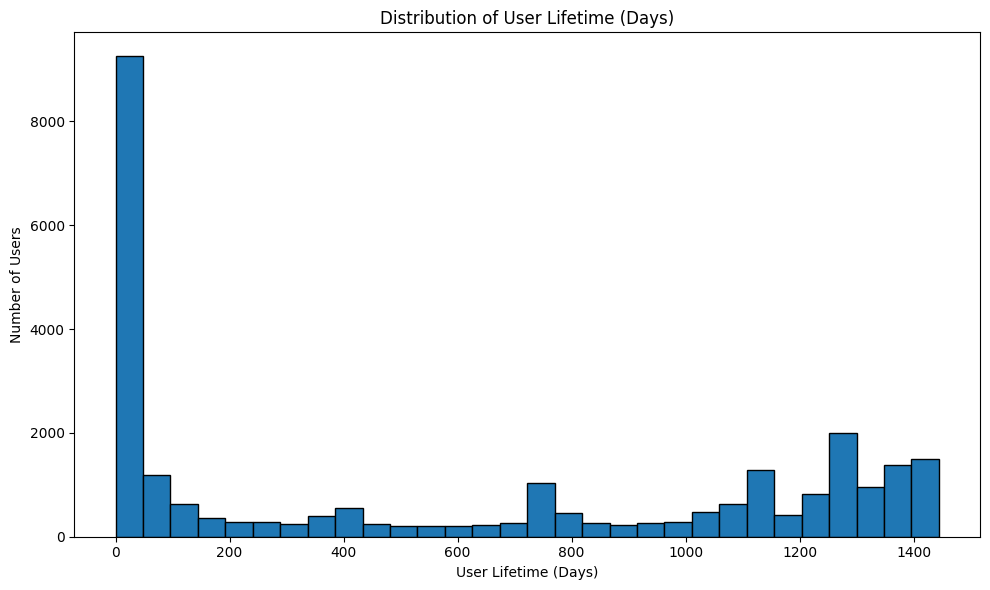

In [42]:
import matplotlib.pyplot as plt

# Drop anomoly entries with signup_dt after first_application_start_ts
valid_user_data = user_data[user_data['signup_dt'] <= user_data['first_application_start_ts']]
valid_user_data['user_lifetime_days'] = (valid_user_data['last_login'] - valid_user_data['signup_dt']).dt.days

plt.figure(figsize=(10, 6))
plt.hist(valid_user_data['user_lifetime_days'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of User Lifetime (Days)')
plt.xlabel('User Lifetime (Days)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


<h4>3.2 How many users reached each stage in the funnel in their user life time?</h4>
<li>Need to notice that these "first" information doesn't nessasarily belong to the same application</li>

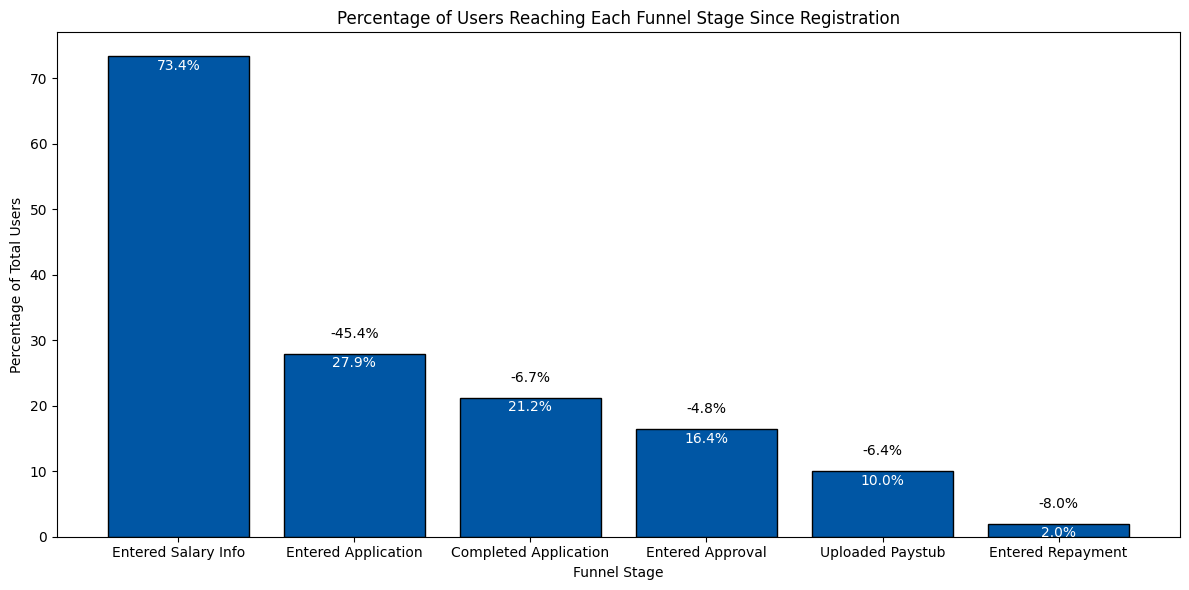

In [43]:
import matplotlib.pyplot as plt

total_users = len(user_data)
stage_percentages = {
    'Entered Salary Info' :(user_data['put_in_salary_info'].sum() / total_users) * 100,
    'Entered Application': (user_data['entered_application'].sum() / total_users) * 100,
    'Completed Application': (user_data['completed_application'].sum() / total_users) * 100,
    'Entered Approval': (user_data['entered_approval'].sum() / total_users) * 100,
    'Uploaded Paystub': (user_data['uploaded_paystub'].sum() / total_users) * 100,
    'Entered Repayment': (user_data['entered_repayment'].sum() / total_users) * 100
}

#Change between each stage of the funnel
stage_keys = list(stage_percentages.keys())
stage_values = list(stage_percentages.values())
stage_changes = [0] + [stage_values[i] - stage_values[i-1] for i in range(1, len(stage_values))]

plt.figure(figsize=(12, 6))
bars = plt.bar(stage_keys, stage_values, color='#0056A4', edgecolor='black')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(i, height - 2.5, f'{height:.1f}%', ha='center', va='bottom', color='white')
    if i > 0:
        plt.text(i, height + 2, f'{stage_changes[i]:.1f}%', ha='center', va='bottom', color='black')
plt.title('Percentage of Users Reaching Each Funnel Stage Since Registration')
plt.xlabel('Funnel Stage')
plt.ylabel('Percentage of Total Users')
plt.tight_layout()
plt.show()


<h4>3.3 Does the spending limit decide if they enter an application?</h4>
<li>Spending limit is not significant predictor. We need to investigate what are the reasons there's a big drop after entering salary info.</li>
<li>One hypotheis would be that what they want to buy is lower than their spending limit</li>

In [44]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

user_data_filtered = user_data.dropna(subset=['spending_limit_est']) # Ignore rows with missing spending limit values

X = user_data_filtered[['spending_limit_est']].values.reshape(-1, 1)
y = user_data_filtered['entered_application']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

beta_lin = lin_reg.coef_[0]
y_pred_lin = lin_reg.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)
residuals = y_train - lin_reg.predict(X_train)
sse = np.sum(residuals**2)
se_beta = np.sqrt(sse / ((len(X_train) - 2) * np.sum((X_train - X_train.mean())**2)))

confidence_interval = stats.norm.interval(0.95, loc=beta_lin, scale=se_beta) #95% confidence interval for the beta coefficient

print(f"Beta Coefficient: {beta_lin:.4f}")
print(f"R-squared: {r2_lin:.4f}")
print(f"95% Confidence Interval for Beta: {confidence_interval}")

Beta Coefficient: 0.0002
R-squared: 0.0065
95% Confidence Interval for Beta: (0.00015614840688416497, 0.0001920512764684712)


<h4>1.4 When do users tend to sign up?</h4>
<li>The spike in user sign-ups aligns closely with a surge in referred users. This suggests to me that the increase in sign-ups was likely driven by a referral program that's possibly tied to a Halloween promotion given the time of the year</li>
<li>What's really promising is even after the peak, the sign-up numbers remain elevated, suggesting a sustained impact of the campaign.</li>
<li>Prepay's targeted users respond very well to the referal programs. This may still be a good customer acquision strategy in the future </li>

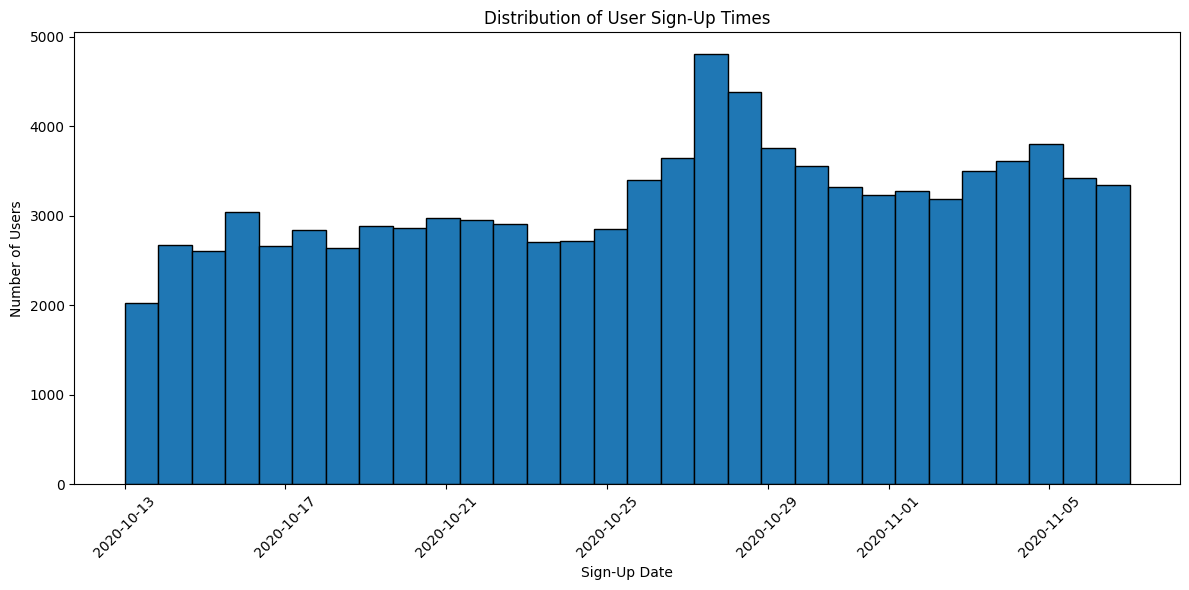

In [45]:
import matplotlib.pyplot as plt

user_data['signup_dt'] = pd.to_datetime(user_data['signup_dt'], errors='coerce')
signup_dates = user_data['signup_dt'].dropna()

plt.figure(figsize=(12, 6))
plt.hist(signup_dates, bins=30, edgecolor='black')
plt.title('Distribution of User Sign-Up Times')
plt.xlabel('Sign-Up Date')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

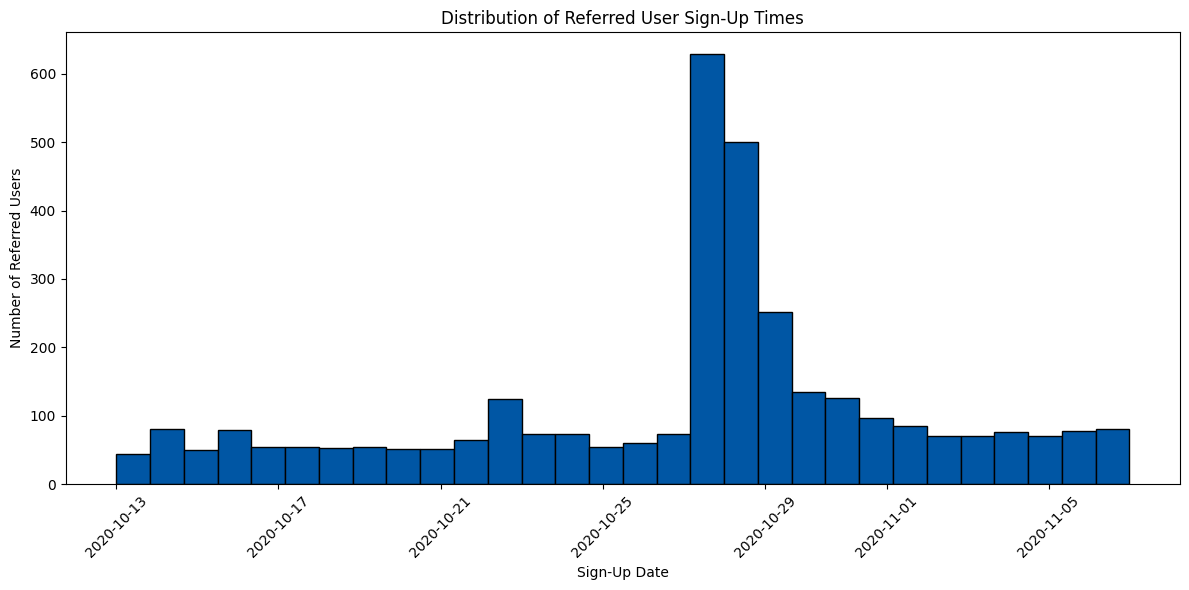

In [46]:
import matplotlib.pyplot as plt

referred_users = user_data[user_data['was_referred_ind'] == 1] #Referred users
referred_signup_dates = referred_users['signup_dt'].dropna()

plt.figure(figsize=(12, 6))
plt.hist(referred_signup_dates, bins=30, edgecolor='black', color='#0056A4')
plt.title('Distribution of Referred User Sign-Up Times')
plt.xlabel('Sign-Up Date')
plt.ylabel('Number of Referred Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# <h2>4. Application Funnel Conversion Analysis</h3>

<h4>4.1 Figure out disctribution of order that have detaied user info for analysis</h4>
<li>Percentage of Customers with user info: 53.03%</li>
<li>Percentage of Customers with no user info: 46.97%</li>


In [47]:
merged_data = pd.merge(order_data, user_data, on='user_id', how='left', indicator=True)
merged_data['is_new_customer'] = merged_data['_merge'].apply(lambda x: 1 if x == 'both' else 0)
total_orders = merged_data.shape[0]
new_customers_count = merged_data[merged_data['is_new_customer'] == 1].shape[0]
existing_customers_count = merged_data[merged_data['is_new_customer'] == 0].shape[0]

#Percentage of new and existing customers
new_customers_percentage = (new_customers_count / total_orders) * 100
existing_customers_percentage = (existing_customers_count / total_orders) * 100

print(f"Percentage of Customers with user info: {new_customers_percentage:.2f}%")
print(f"Percentage of Customers with no user info: {existing_customers_percentage:.2f}%")


Percentage of Customers with user info: 53.03%
Percentage of Customers with no user info: 46.97%


<h4>Problem Identified: Data is not super reliable because we are observing amount above spending limit

In [48]:
# New users only ,only orders that reached the completed_application stage
new_users = merged_data[merged_data['is_new_customer'] == 1]
new_users_completed = new_users[new_users['entered_repayment_x'] == 1]

total_order_by_user_completed = new_users_completed.groupby('user_id').agg(
    total_amount=('amount', 'sum'),
    order_count=('amount', 'size')
).reset_index()

total_order_with_spending_limit_completed = pd.merge(
    total_order_by_user_completed,
    new_users[['user_id', 'spending_limit_est','cancellation_type']].drop_duplicates(),
    on='user_id',
    how='left'
)

exceeding_limit_completed = total_order_with_spending_limit_completed[
    total_order_with_spending_limit_completed['total_amount'] > total_order_with_spending_limit_completed['spending_limit_est']
]

exceeding_limit_completed_count = exceeding_limit_completed.shape[0]
print (exceeding_limit_completed)
print ("count: ",exceeding_limit_completed_count)


                                  user_id  total_amount  order_count  \
65   0b7f33f2-2beb-4e67-b150-acb9c758ded0       1099.78            1   
66   0b7f33f2-2beb-4e67-b150-acb9c758ded0       1099.78            1   
77   0ef13870-f8fa-4e3e-9357-661aa29a04eb        829.98            1   
114  19a6a672-7145-4c49-9219-f9792389e8de       1396.88            1   
115  19a6a672-7145-4c49-9219-f9792389e8de       1396.88            1   
116  19a6a672-7145-4c49-9219-f9792389e8de       1396.88            1   
134  1c6a2d68-1a86-43af-bef6-fa0e33ff41fa       1025.96            1   
142  1fa56803-9136-4112-98e3-5c49f4e7e484        789.96            1   
145  2109f098-313e-4e6d-abf4-a47d2aa39659       1527.95            1   
191  327331d3-34ae-4f08-bce2-2dd336d3f012       1117.23            1   
192  327331d3-34ae-4f08-bce2-2dd336d3f012       1117.23            1   
243  3e634d96-b9a2-46c9-b6e3-86935f2b3edc       1169.98            1   
244  3e634d96-b9a2-46c9-b6e3-86935f2b3edc       1169.98         

<h4>4.2 What's the conversion rate by stage for new and existing customers?

<li>Different conversion rates is suggesting segmentation of customers.

<li> Overall, higher spending limit is leading to higher conversion rate from application started to repayment. This shows that customers with higher spending limits are more committed to completing the journey through to repayment. These users likely have a stronger intent to make a purchase and are more likely to have the financial means to follow through. But the conversion rate drop significantly in repayment. This means that to increase conversion, Prepay can potentially give communicate clearer to reduce friction and encourage users to proceed with repayment.</li>

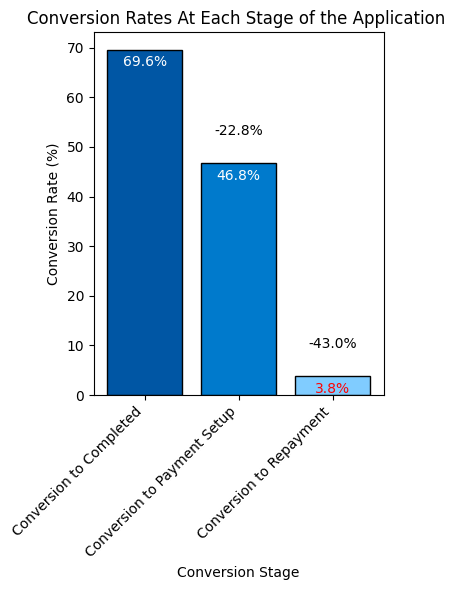

In [49]:
import matplotlib.pyplot as plt

#Calculate conversion rates
conversion_all = {
    'Conversion to Completed': (merged_data['completed_application_x'].sum() / merged_data['entered_application_x'].sum()) * 100,
    'Conversion to Payment Setup': (merged_data['entered_awaiting_payment'].sum() / merged_data['entered_application_x'].sum()) * 100,
    'Conversion to Repayment': (merged_data['entered_repayment_x'].sum() / merged_data['entered_application_x'].sum()) * 100
}
#Calculate reduction from the last stage
reduction_all = {
    'Reduction to Payment Setup': conversion_all['Conversion to Payment Setup'] - conversion_all['Conversion to Completed'],
    'Reduction to Repayment': conversion_all['Conversion to Repayment'] - conversion_all['Conversion to Payment Setup']
}

colors = ['#0056A4', '#007ACC', '#80CCFF']
fig, ax = plt.subplots(figsize=(4, 6))
bars = ax.bar(conversion_all.keys(), conversion_all.values(), color=colors, edgecolor='black')
for i, bar in enumerate(bars):
    height = bar.get_height()
    index = bar.get_x() + bar.get_width() / 2

    total_label = f'{height:.1f}%'
    text_color = 'red' if i == 2 else 'white'
    ax.text(index, height - 4, total_label, ha='center', va='bottom', color=text_color)
    if i > 0:
        reduction_label = f'{reduction_all[list(reduction_all.keys())[i-1]]:+.1f}%'
        ax.text(index, height + 5, reduction_label, ha='center', va='bottom', color='black')
ax.set_title('Conversion Rates At Each Stage of the Application ')
ax.set_xlabel('Conversion Stage')
ax.set_ylabel('Conversion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<ipython-input-50-80bcc57ae91d>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_by_limit = merged_data.groupby('spending_limit_category').agg(


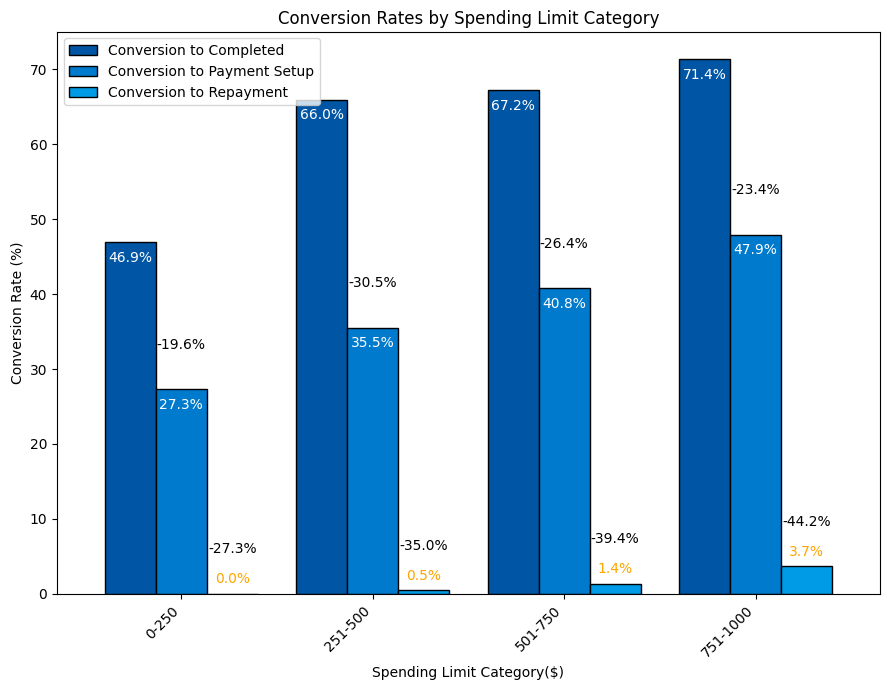

In [50]:
import matplotlib.pyplot as plt

bins = [0, 250, 500, 750, 1000] #spending limits  beean (max is 1000)
labels = ['0-250', '251-500', '501-750', '751-1000']
merged_data['spending_limit_category'] = pd.cut(merged_data['spending_limit_est'], bins=bins, labels=labels)

#Conversion rates for each spending limit category
conversion_by_limit = merged_data.groupby('spending_limit_category').agg(
    total_applications=('application_start_ts', 'count'),
    completed_applications=('application_complete_ts', 'count'),
    awaiting_payment=('awaiting_payment_ts', 'count'),
    repayment=('repayment_ts', 'count')
)

conversion_by_limit['Conversion to Completed'] = (conversion_by_limit['completed_applications'] / conversion_by_limit['total_applications']) * 100
conversion_by_limit['Conversion to Payment Setup'] = (conversion_by_limit['awaiting_payment'] / conversion_by_limit['total_applications']) * 100
conversion_by_limit['Conversion to Repayment'] = (conversion_by_limit['repayment'] / conversion_by_limit['total_applications']) * 100

# Reduction from the last stage for each bin
conversion_by_limit['Reduction to Completed'] = conversion_by_limit['Conversion to Completed']
conversion_by_limit['Reduction to Payment Setup'] = conversion_by_limit['Conversion to Payment Setup'] - conversion_by_limit['Conversion to Completed']
conversion_by_limit['Reduction to Repayment'] = conversion_by_limit['Conversion to Repayment'] - conversion_by_limit['Conversion to Payment Setup']

conversion_rate_columns = ['Conversion to Completed',
                            'Conversion to Payment Setup', 'Conversion to Repayment']
reduction_columns = ['Reduction to Completed',
                     'Reduction to Payment Setup', 'Reduction to Repayment']
colors = ['#0056A4', '#007ACC', '#009BE6']
fig, ax = plt.subplots(figsize=(9, 7))
conversion_by_limit[conversion_rate_columns].plot(kind='bar', ax=ax, color=colors, edgecolor='black', width=0.8)
for i, bar_container in enumerate(ax.containers):
    for j, bar in enumerate(bar_container):
        height = bar.get_height()
        index = bar.get_x() + bar.get_width() / 2

        total_label = f'{height:.1f}%'
        reduction_label = f'{conversion_by_limit[reduction_columns[i]].iloc[j]:+.1f}%'
        if i == 2:  # Only for the "Conversion to Repayment" category
            ax.text(index, height + 1, total_label, ha='center', va='bottom', color='orange')
        else:
            ax.text(index, height - 3, total_label, ha='center', va='bottom', color='white')
        if i > 0:  # Exclude reduction for "Conversion to Completed"
            ax.text(index, height + 5, reduction_label, ha='center', va='bottom', color='black')

ax.set_title('Conversion Rates by Spending Limit Category')
ax.set_xlabel('Spending Limit Category($)')
ax.set_ylabel('Conversion Rate (%)')
ax.legend(loc='center left', bbox_to_anchor=(0, 0.93))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Existing customers are more likley to reach repayment than new customers

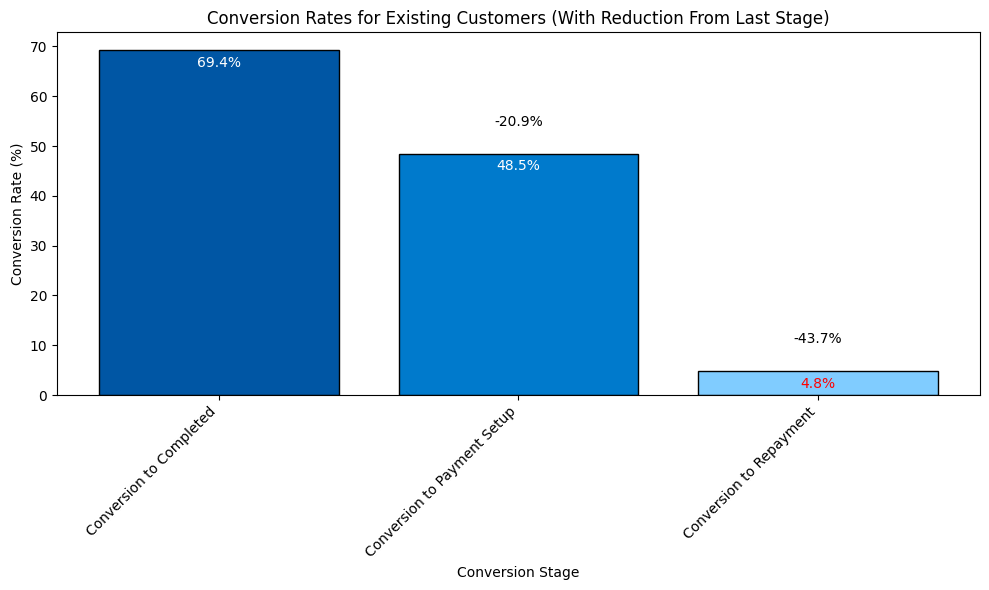

In [51]:
import matplotlib.pyplot as plt
existing_customers = merged_data[merged_data['is_new_customer'] == 0]
conversion_existing = {
    'Conversion to Completed': (existing_customers['completed_application_x'].sum() / existing_customers['entered_application_x'].sum()) * 100,
    'Conversion to Payment Setup': (existing_customers['entered_awaiting_payment'].sum() / existing_customers['entered_application_x'].sum()) * 100,
    'Conversion to Repayment': (existing_customers['entered_repayment_x'].sum() / existing_customers['entered_application_x'].sum()) * 100
}
reduction_existing = {
    'Reduction to Payment Setup': conversion_existing['Conversion to Payment Setup'] - conversion_existing['Conversion to Completed'],
    'Reduction to Repayment': conversion_existing['Conversion to Repayment'] - conversion_existing['Conversion to Payment Setup']
}

colors = ['#0056A4', '#007ACC', '#80CCFF']
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(conversion_existing.keys(), conversion_existing.values(), color=colors, edgecolor='black')
for i, bar in enumerate(bars):
    height = bar.get_height()
    index = bar.get_x() + bar.get_width() / 2

    total_label = f'{height:.1f}%'
    text_color = 'red' if i == 2 else 'white'
    ax.text(index, height - 4, total_label, ha='center', va='bottom', color=text_color)
    if i > 0:
        reduction_label = f'{reduction_existing[list(reduction_existing.keys())[i-1]]:+.1f}%'
        ax.text(index, height + 5, reduction_label, ha='center', va='bottom', color='black')
ax.set_title('Conversion Rates for Existing Customers (With Reduction From Last Stage)')
ax.set_xlabel('Conversion Stage')
ax.set_ylabel('Conversion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<h4>4.3 What are the reasons that users cancel their order?

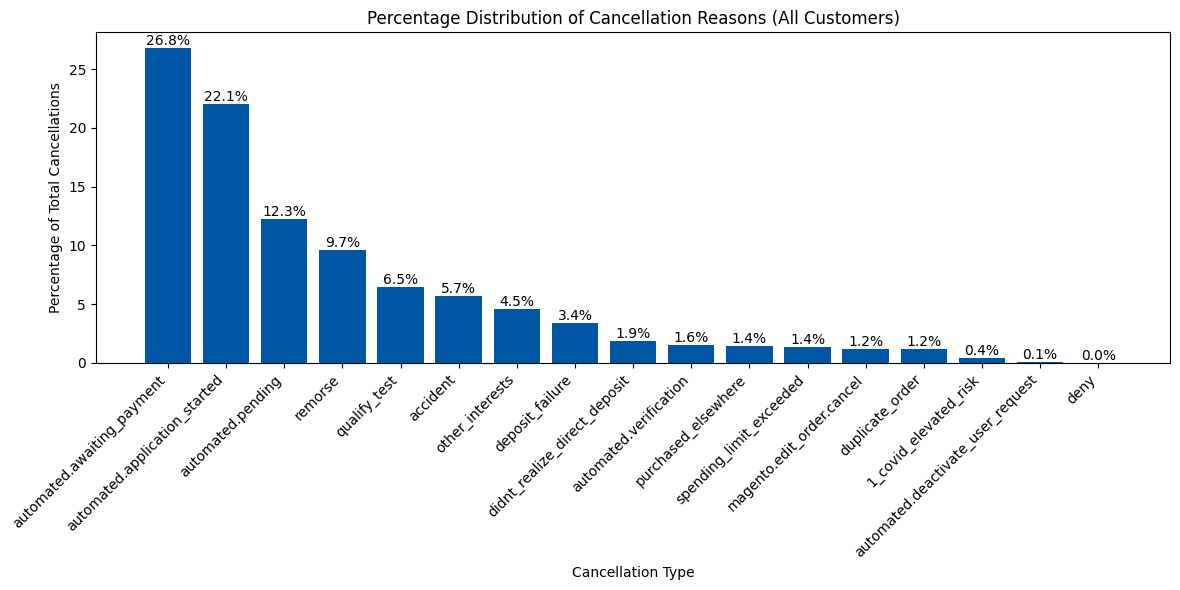

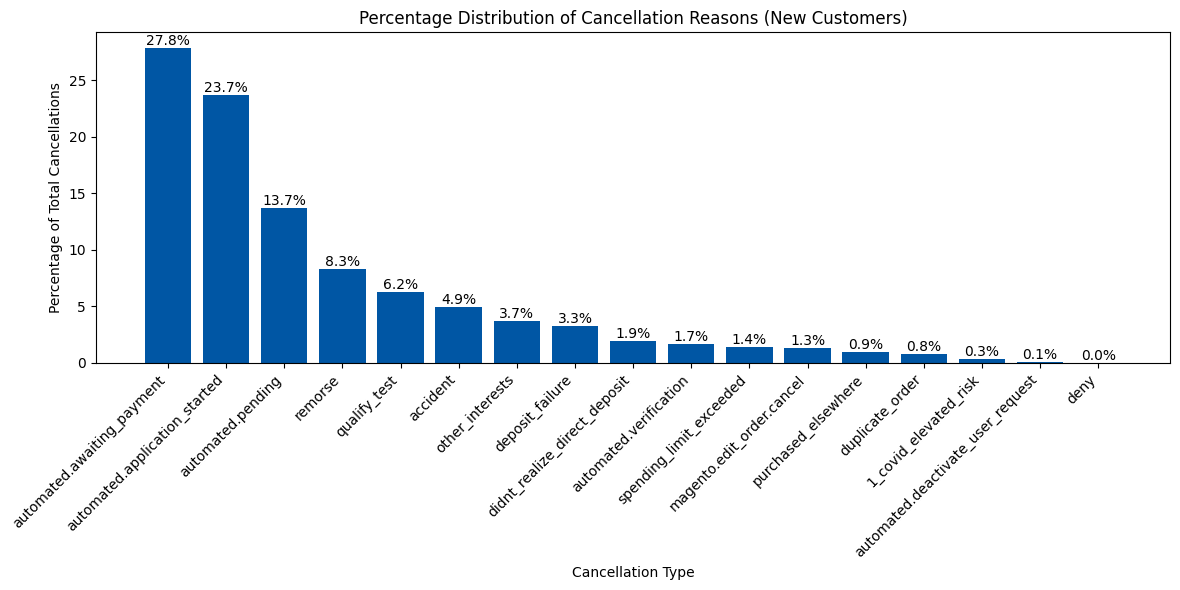

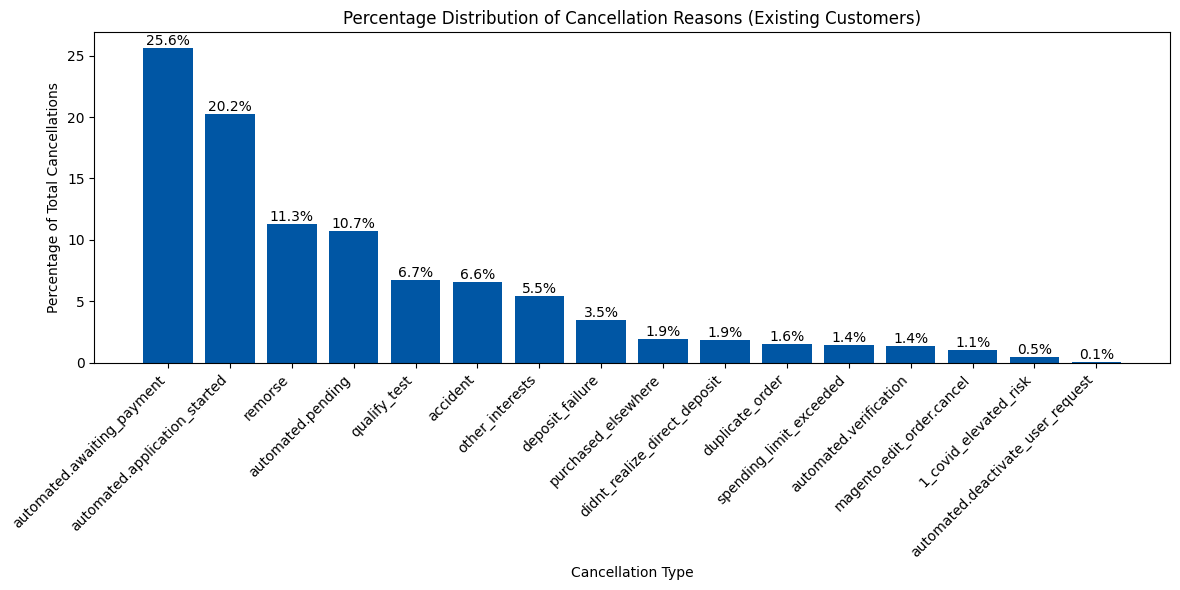

In [52]:
import matplotlib.pyplot as plt


def plot_cancellation_reasons_percentage(data, customer_type):
    cancellation_reasons = data['cancellation_type'].value_counts() #Cancellation reasons count
    cancellation_percentages = (cancellation_reasons / cancellation_reasons.sum()) * 100

    color = '#0056A4'
    plt.figure(figsize=(12, 6))
    plt.bar(cancellation_percentages.index, cancellation_percentages.values, color=color)
    for i, value in enumerate(cancellation_percentages.values):
        plt.text(i, value, f'{value:.1f}%', ha='center', va='bottom')
    plt.title(f'Percentage Distribution of Cancellation Reasons ({customer_type} Customers)')
    plt.xlabel('Cancellation Type')
    plt.ylabel('Percentage of Total Cancellations')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


new_customers = merged_data[merged_data['is_new_customer'] == 1]
existing_customers = merged_data[merged_data['is_new_customer'] == 0]


plot_cancellation_reasons_percentage(merged_data, 'All') #cancellation reasons for all users
plot_cancellation_reasons_percentage(new_customers, 'New') #cancellation reasons for new customers
plot_cancellation_reasons_percentage(existing_customers, 'Existing') #cancellation reasons for existing customers


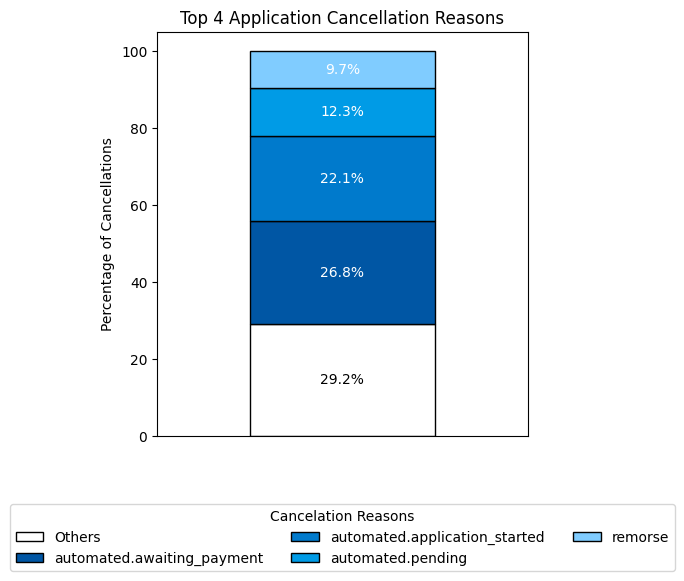

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_cancellation_reasons(data, title='All Orders'):
    top_cancellations = pd.DataFrame()
    #Find top 4 cancellation reasons plus "Others"
    top_reasons = data['cancellation_type'].value_counts().nlargest(4)
    others = data['cancellation_type'].value_counts().sum() - top_reasons.sum()
    top_reasons['Others'] = others
    top_reasons = (top_reasons / top_reasons.sum()) * 100
    top_reasons = top_reasons.reindex(['Others'] + [col for col in top_reasons.index if col != 'Others'])


    top_cancellations = pd.DataFrame({'Percentage': top_reasons})
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = ['white'] + ['#0056A4', '#007ACC', '#009BE6', '#80CCFF']
    top_cancellations.T.plot(kind='bar', stacked=True, color=colors, edgecolor='black', ax=ax)
    for i, bar_container in enumerate(ax.containers):
        for bar in bar_container:
            height = bar.get_height()
            if height > 0:  #Only label non-zero bars
                color = 'black' if bar.get_y() == 0 else 'white'
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1f}%',
                        ha='center', va='center', color=color, fontsize=10)
    ax.set_title(f'Top 4 Application Cancellation Reasons')
    ax.set_ylabel('Percentage of Cancellations')
    ax.set_xlabel('')
    ax.set_xticks([])
    plt.legend(top_cancellations.index, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, title='Cancelation Reasons')
    plt.tight_layout()
    plt.show()

plot_stacked_cancellation_reasons(merged_data, title='All Orders')


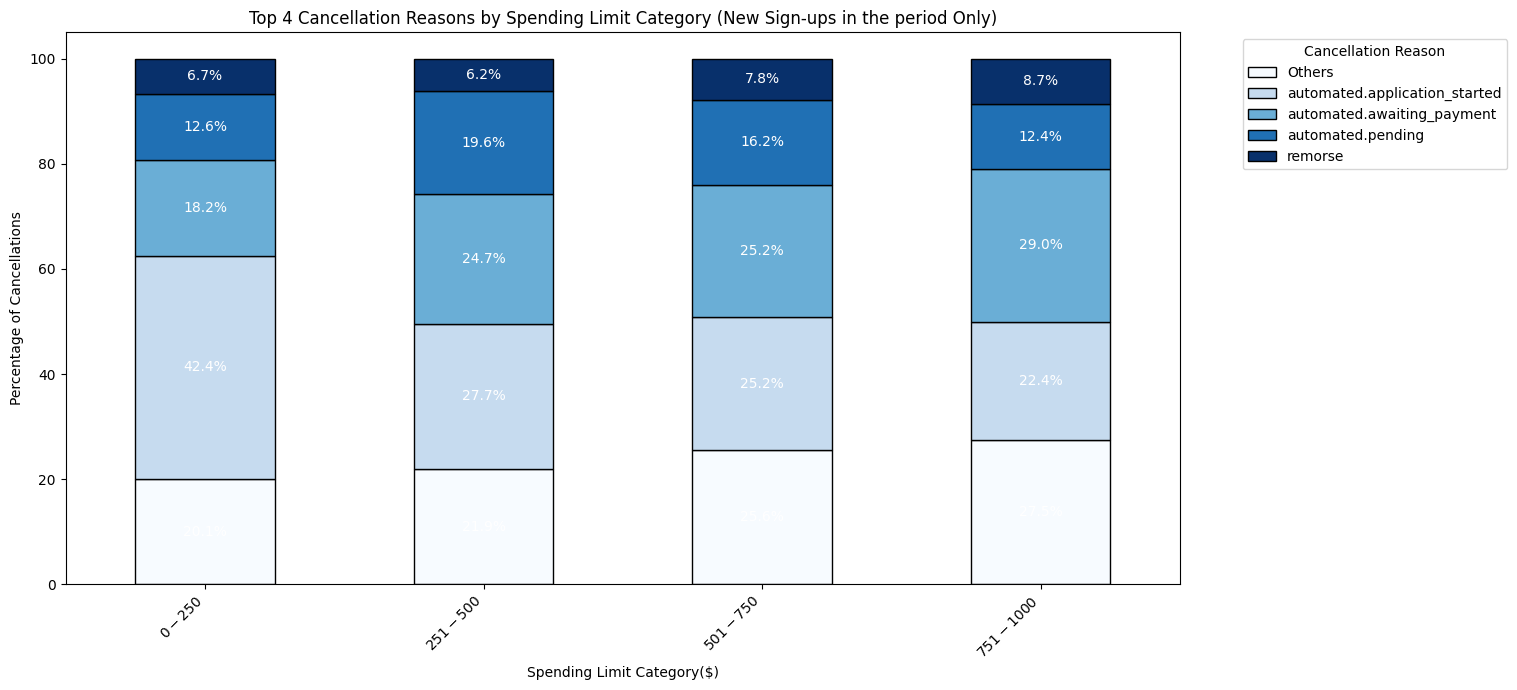

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bins = [0, 250, 500, 750, 1000]
labels = ['$0-$250', '$251-$500', '$501-$750', '$751-$1000']
merged_data['spending_limit_category'] = pd.cut(merged_data['spending_limit_est'], bins=bins, labels=labels)
new_users = merged_data[merged_data['is_new_customer'] == 1]
top_cancellations = pd.DataFrame()

#Find top 4 cancellation reasons plus "Others" for each spending limit group
for group in labels:
    data_filtered = new_users[new_users['spending_limit_category'] == group]
    top_reasons = data_filtered['cancellation_type'].value_counts().nlargest(4)
    others = data_filtered['cancellation_type'].value_counts().sum() - top_reasons.sum()  # Count of other reasons
    top_reasons['Others'] = others  # Add 'Others' to the top reasons
    top_reasons = (top_reasons / top_reasons.sum()) * 100
    temp_df = pd.DataFrame({'Cancellation Reason': top_reasons.index,
                            'Percentage': top_reasons.values,
                            'Spending Limit': group})
    top_cancellations = pd.concat([top_cancellations, temp_df])

#stack columns
pivot_data = top_cancellations.pivot(index='Spending Limit', columns='Cancellation Reason', values='Percentage').fillna(0)
pivot_data = pivot_data.apply(lambda x: x.sort_values(ascending=False), axis=1)
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', stacked=True, ax=ax, colormap='Blues', edgecolor='black')

for i, bar_container in enumerate(ax.containers):
    for bar in bar_container:
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1f}%',
                    ha='center', va='center', color='white', fontsize=10)

ax.set_title('Top 4 Cancellation Reasons by Spending Limit Category (New Sign-ups in the period Only)')
ax.set_xlabel('Spending Limit Category($)')
ax.set_ylabel('Percentage of Cancellations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Cancellation Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<h4>4.4 Time from approval to repayment below and above 15 days</h4>

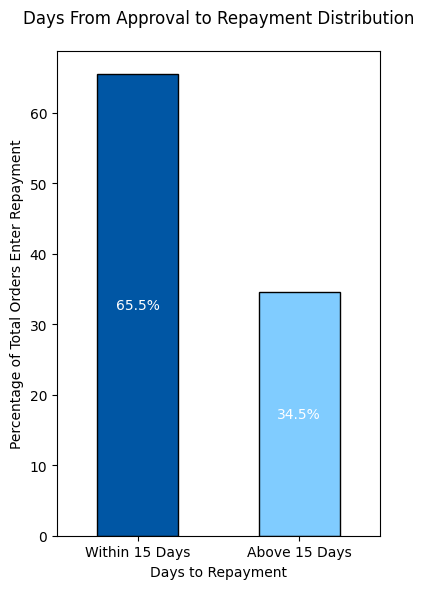

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

merged_data['days_to_repayment'] = (merged_data['repayment_ts'] - merged_data['awaiting_payment_ts']).dt.days
mean_repayment_time = merged_data['days_to_repayment'].mean()
median_repayment_time = merged_data['days_to_repayment'].median()
bins = [0, 15, float('inf')]
labels = ['Within 15 Days', 'Above 15 Days']

#Classify orders based on days to repayment
merged_data['repayment_category'] = pd.cut(merged_data['days_to_repayment'], bins=bins, labels=labels, right=False)
#Count the number of orders in each category
repayment_distribution = merged_data['repayment_category'].value_counts().sort_index()
repayment_distribution_percentage = (repayment_distribution / repayment_distribution.sum()) * 100 #percentage


fig, ax = plt.subplots(figsize=(4, 6))
repayment_distribution_percentage.plot(kind='bar', ax=ax, color=['#0056A4', '#80CCFF'], edgecolor='black')
for i, value in enumerate(repayment_distribution_percentage.values):
    if value > 0:  # Only label non-zero bars
        ax.text(i, value / 2, f'{value:.1f}%', ha='center', va='center', color='white', fontsize=10)

ax.set_title('Days From Approval to Repayment Distribution', pad=20)
ax.set_xlabel('Days to Repayment')
ax.set_ylabel('Percentage of Total Orders Enter Repayment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
